<h1 style="color:rgb(0,120,170)">Neural Networks and Deep Learning</h1>
<h2 style="color:rgb(0,120,170)">Intro to Tensor Flow and Keras - ANN</h2>

#### [Predicting New York City rental prizes from Airbnb](https://www.analyticsvidhya.com/blog/2020/10/predicting-nyc-airbnb-rental-prices-tensorflow/)

In [1]:
# !pip install -U tensorflow tensorboard matplotlib

In [2]:
import os
import sys
#import re
import time
import datetime
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorboard.plugins.hparams import api_pb2
from tensorboard.plugins.hparams import summary as hparams_summary
%load_ext tensorboard

from google.protobuf import struct_pb2

In [3]:
print(tf.__version__)
try:
    physical_devices = tf.config.list_physical_devices('GPU') 
    #tf.config.experimental.set_memory_growth(physical_devices[0], True)
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
    print(physical_devices)
except:
    print("No GPU")

2.8.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-02-19 10:29:26.038412: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-19 10:29:26.066548: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-19 10:29:26.066710: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


We're pulling the data straight off the kaggle website. We could also download the archive zip file, but we're going to use the csv file directly. Note: by using the -o flag we're specifying the output filename. Mine is airbnb.csv. You can of course use any name you'd like, just note to pass it as to pandas' read_csv function. 

!wget -o ../../Data/airbnb.csv https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data?select=AB_NYC_2019.csv

In [4]:
path='../../../data/airbnb.csv'
df = pd.read_csv(path)
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

Seaborn has a great plotting API. Let's use it to plot the correlation matrix. Change the figsize parameters for the size of the canvas. 

<AxesSubplot:>

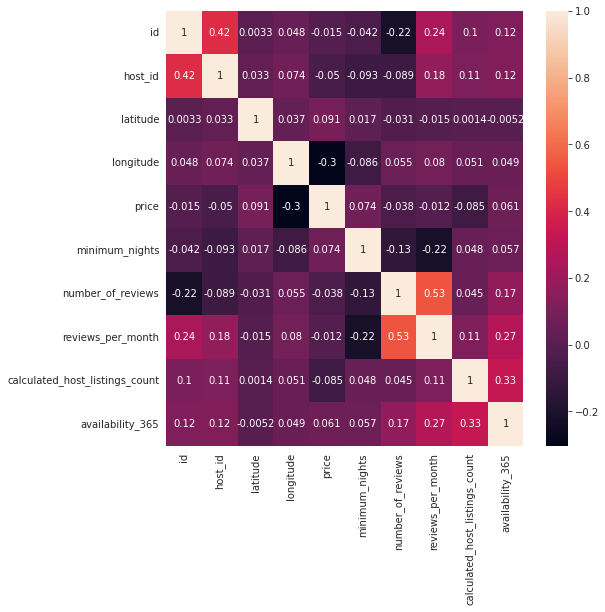

In [6]:
corr = df.corr(method='kendall')
plt.figure(figsize=(8,8))
sns.heatmap(corr, annot=True)

Next, we'll remove the duplicates and deal with NAN values in the column 'reviews_per_month'.

In [7]:
df.duplicated().sum()

0

In [8]:
df.drop_duplicates(inplace=True)
df['reviews_per_month']=df['reviews_per_month'].fillna(0)

Dropping unnecessary columns will make it easier to train our model. Unnecessary is data that has low correlation with the model's prediction.  
Let's take a look at the types after dropping columns.  

In [9]:
df.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [10]:
columns = ['id', 'host_id', 'name', 'host_name', 'last_review', 'calculated_host_listings_count']
df = df.drop(columns,axis=1)
df.isnull().sum()

neighbourhood_group    0
neighbourhood          0
latitude               0
longitude              0
room_type              0
price                  0
minimum_nights         0
number_of_reviews      0
reviews_per_month      0
availability_365       0
dtype: int64

In [11]:
df.dtypes

neighbourhood_group     object
neighbourhood           object
latitude               float64
longitude              float64
room_type               object
price                    int64
minimum_nights           int64
number_of_reviews        int64
reviews_per_month      float64
availability_365         int64
dtype: object

By using the countplot we'll receive the visual information about which neighbourhood group is the most popular for renting via AirBnb. 

Text(0.5, 1.0, 'Neighbourhood')

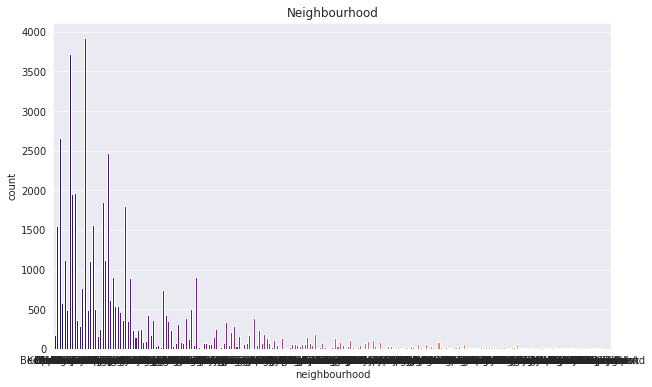

In [12]:
sns.countplot(df['neighbourhood'], palette="plasma")
fig = plt.gcf()
fig.set_size_inches(10,6)
plt.title('Neighbourhood')

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

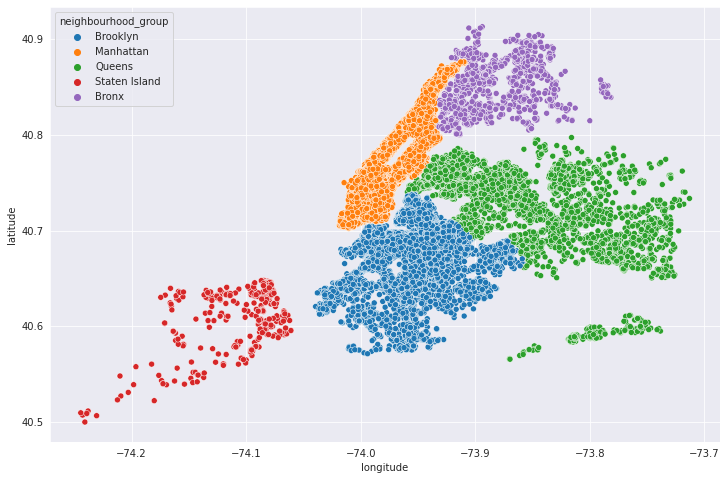

In [13]:
plot_dims=(12,8)
plt.figure(figsize=plot_dims)
sns.scatterplot(df.longitude, df.latitude, hue=df.neighbourhood_group)
#plt.ioff()

Next, we'll one-hot encode certain columns for training.

In [14]:
df['neighbourhood_group'] = pd.factorize(df.neighbourhood_group)[0]
df['neighbourhood'] = pd.factorize(df.neighbourhood)[0]
df['room_type'] = pd.factorize(df.room_type)[0]

df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365
0,0,0,40.64749,-73.97237,0,149,1,9,0.21,365
1,1,1,40.75362,-73.98377,1,225,1,45,0.38,355
2,1,2,40.80902,-73.94190,0,150,3,0,0.00,365
3,0,3,40.68514,-73.95976,1,89,1,270,4.64,194
4,1,4,40.79851,-73.94399,1,80,10,9,0.10,0


In [15]:
# Normalizing the availability column so that its values don't return out of the box loss results while training.
# The column's mean is 0 and standard deviation is 1 

availabillity=df['availability_365']
availabillity=(availabillity-availabillity.mean())/availabillity.std()

In [16]:
df.shape

(48895, 10)

Here I created separate datasets for columns and labels. Note that the X dataset does not remove the price label. Remember we are trying to predict the price based on the training data. 

Data shapes don't match, so I've decided to truncate it.

In [17]:
Y = df['price']
X = df.copy()
X = X.drop(X['price'])

X.shape, Y.shape

((48221, 10), (48895,))

In [18]:
Y = Y.truncate(after=48220, axis=0)
X.shape, Y.shape

((48221, 10), (48221,))

Next up are the feature crosses.
The point is to merge the two columns, so that its values are representative of the data. Our goal here is to feature cross longitude and landitute, which is one old trick. If we put merely the two columns as values to the model, it will assume those values are progressively related to the output. 

Instead, we'll be using a feature cross, meaning we will split the longitude*langitude map into a grid. 
Quite a delicate little problem. Lucky for us, Tensorflow makes it easy. 

I'm making a grid of equally spreaded grids by iterating from the minimum to the maximum value with an iteration of (max-min)/100.
I'm using a 100x100 grid. 

In [19]:
max_long = df['longitude'].max()
min_long = df['longitude'].min()

diff = max_long-min_long
diff/=100

long_boundaries = []
for i in np.arange(min_long, max_long, diff):
    long_boundaries.append(min_long+i*diff)

    
max_lat = df['latitude'].max()
min_lat = df['latitude'].min()

d = max_lat-min_lat
d /= 100

lat_boundaries = []
for i in np.arange(min_lat, max_lat, d):
    lat_boundaries.append(min_long + i*d)
    

Essentially, what we're doing here, is defining a bucketized column with boundaries defined earlier and creating a DenseFeatures layer, which will be passed to the Sequential API later. 


If you're not familiar with the Tensorflow syntax, do check the docs [here](https://www.tensorflow.org/api_docs/python/tf/feature_column/) and [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/DenseFeatures)  

In [20]:
long_marked = tf.feature_column.bucketized_column(tf.feature_column.numeric_column('longitude'), 
                                                  boundaries=long_boundaries)

lat_marked = tf.feature_column.bucketized_column(tf.feature_column.numeric_column('latitude'), 
                                                 boundaries=lat_boundaries)

crossed_feature = tf.feature_column.crossed_column([long_marked, 
                                                    lat_marked], 
                                                   hash_bucket_size=100)

feature_layer = tf.feature_column.indicator_column(crossed_feature)

In the following sections, we'll finally prepare the data for training using the sklearn's train_test_split and the StandardScaler function.


In [21]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test=train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=0)

In [22]:
x_train.shape, x_test.shape

((38576, 10), (9645, 10))

In [23]:
y_train.shape, y_test.shape

((38576,), (9645,))

In [24]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.transform(x_test)

Again, sklearn makes it super easy to define this hard architectures.  
First, linear regression, which shouldn't work well because this isn't a regression task. 

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
linreg = LinearRegression()
linreg.fit(x_train,y_train)
y_pred = linreg.predict(x_test)
r2score = r2_score(y_test,y_pred)
r2score

-0.0005691749531513413

Then, the notorious support vector machine. 

In [26]:
from sklearn.svm import SVC

svc = SVC(kernel='linear')
svc.fit(x_train, y_train)
r2score = r2_score(y_test, y_pred)
r2score

-0.0005691749531513413

Finally, the creation of the keras Sequential model. 

We' re compiling the model using the Adam optimizer, MSE loss and two metrics. Keep track of these while the model trains. 

In [27]:
tf.keras.backend.set_floatx('float32')

model = tf.keras.Sequential([
    #tf.keras.layers.DenseFeatures(feature_layer, trainable=True),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

opt = tf.keras.optimizers.Adam(learning_rate=0.05)
rmse = tf.keras.metrics.RootMeanSquaredError()
model.compile(optimizer=opt,loss='mean_squared_error',metrics=['mae',rmse])

2022-02-19 10:31:14.162747: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-19 10:31:14.163248: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-19 10:31:14.163570: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-19 10:31:14.163691: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Additionally, we are using two callbacks

EarlyStopping, which is self explanatory, but check the docs 
   - https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
    
Reduce learning rate on plateau.
  - https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau

In [28]:
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=2,factor=0.2)
early_stopper = tf.keras.callbacks.EarlyStopping(patience=5)
callbacks = [lr_reducer,early_stopper]

history = model.fit(x_train,
                    y_train,
                    validation_data=(x_test,y_test), 
                    callbacks=callbacks,
                    epochs=50,
                    batch_size=64,
                    verbose=2)

#model.summary()

Epoch 1/50
603/603 - 2s - loss: 61867.4141 - mae: 95.9057 - root_mean_squared_error: 248.7316 - val_loss: 52832.6211 - val_mae: 84.9530 - val_root_mean_squared_error: 229.8535 - lr: 0.0500 - 2s/epoch - 3ms/step
Epoch 2/50
603/603 - 1s - loss: 61048.7344 - mae: 95.1505 - root_mean_squared_error: 247.0804 - val_loss: 52495.7227 - val_mae: 85.0610 - val_root_mean_squared_error: 229.1194 - lr: 0.0500 - 862ms/epoch - 1ms/step
Epoch 3/50
603/603 - 1s - loss: 60618.1992 - mae: 94.2229 - root_mean_squared_error: 246.2076 - val_loss: 51953.4570 - val_mae: 91.7869 - val_root_mean_squared_error: 227.9330 - lr: 0.0500 - 890ms/epoch - 1ms/step
Epoch 4/50
603/603 - 1s - loss: 60524.2891 - mae: 93.9836 - root_mean_squared_error: 246.0168 - val_loss: 51921.1406 - val_mae: 90.2184 - val_root_mean_squared_error: 227.8621 - lr: 0.0500 - 877ms/epoch - 1ms/step
Epoch 5/50
603/603 - 1s - loss: 60313.8008 - mae: 93.4844 - root_mean_squared_error: 245.5887 - val_loss: 52361.5859 - val_mae: 85.7954 - val_root_

In [29]:
history_df = pd.DataFrame(history.history)
history_df.head()

,loss,mae,root_mean_squared_error,val_loss,val_mae,val_root_mean_squared_error,lr
0,61867.414062,95.905670,248.731613,52832.621094,84.953026,229.853470,0.05
1,61048.734375,95.150536,247.080414,52495.722656,85.061020,229.119446,0.05
2,60618.199219,94.222939,246.207626,51953.457031,91.786858,227.933014,0.05
3,60524.289062,93.983620,246.016846,51921.140625,90.218430,227.862106,0.05
4,60313.800781,93.484398,245.588684,52361.585938,85.795425,228.826538,0.05


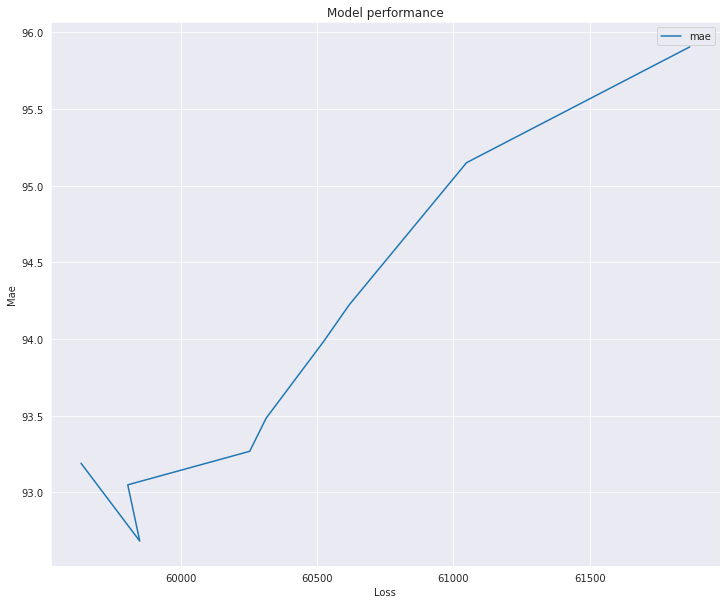

In [30]:
history_df.plot(x='loss',y='mae', figsize=(12,10))
plt.xlabel('Loss')
plt.ylabel('Mae')
plt.title("Model performance")
plt.show()